In [1]:
#importazione del df
import pandas as pd
df = pd.read_csv('csv/decessi_tot.csv')
df.head()

,Data,Totale
0,2015-01-01,2632
1,2015-01-02,2182
2,2015-01-03,2215
3,2015-01-04,2264
4,2015-01-05,2301


In [2]:
#trasformo le date e i numeri
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df.Totale = pd.to_numeric(df.Totale)
df.head()

,Data,Totale
0,2015-01-01,2632
1,2015-01-02,2182
2,2015-01-03,2215
3,2015-01-04,2264
4,2015-01-05,2301


In [3]:
#metto il campo 'Data' come indice
df=df.set_index('Data')
df.head()

,Totale
Data,
2015-01-01,2632
2015-01-02,2182
2015-01-03,2215
2015-01-04,2264
2015-01-05,2301


In [4]:
#creo la time series
ts = df.Totale
ts.head()

Data
2015-01-01    2632
2015-01-02    2182
2015-01-03    2215
2015-01-04    2264
2015-01-05    2301
Name: Totale, dtype: int64

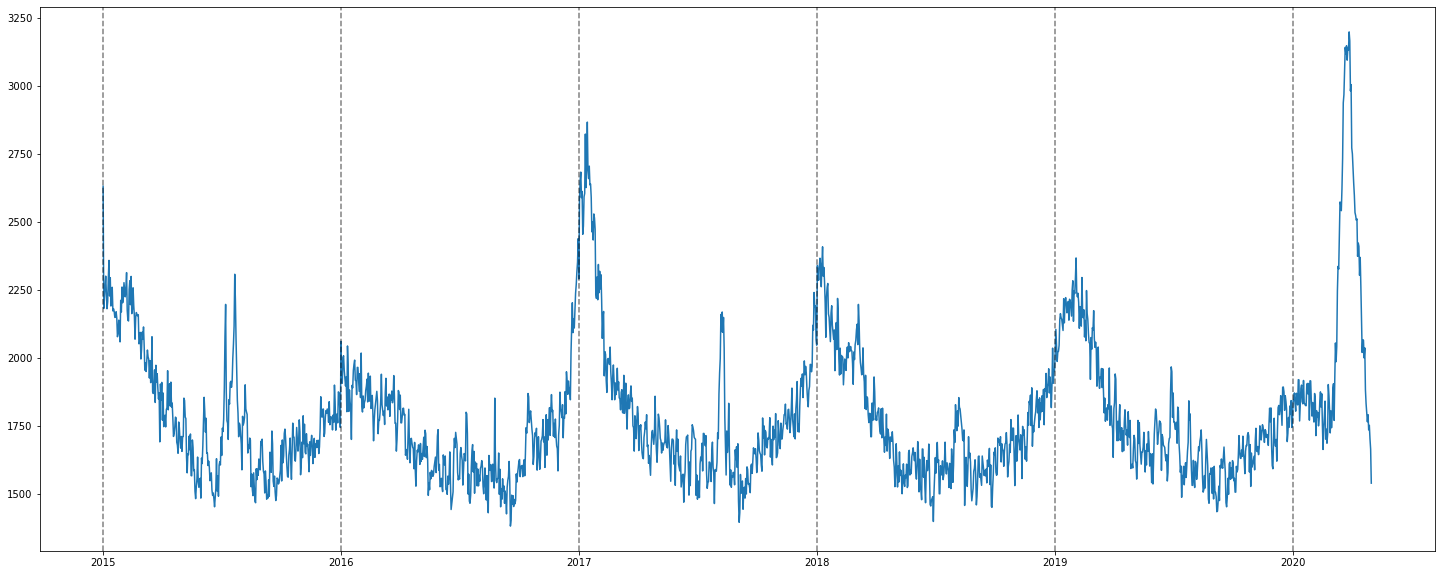

In [5]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2015,1,1)
end_date = datetime(2020,4,30)
lim_ts = ts[start_date:end_date]

#visulizzo il grafico della time series
import matplotlib.pyplot as plt
plt.figure(figsize=(25,10))
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

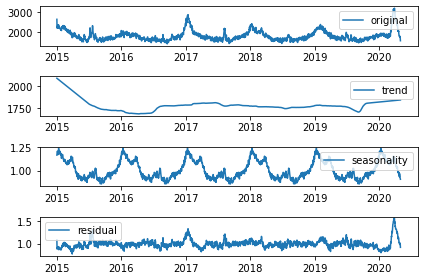

In [153]:
#decomposizione della serie in trend, stagionalità e residui
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=365, two_sided=True, extrapolate_trend=1, model='multiplicative')

ts_trend = decomposition.trend #andamento della curva
ts_seasonal = decomposition.seasonal #stagionalità 
ts_residual = decomposition.resid #parti rimanenti
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

In [154]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
    else:
        print("X is not stationary")

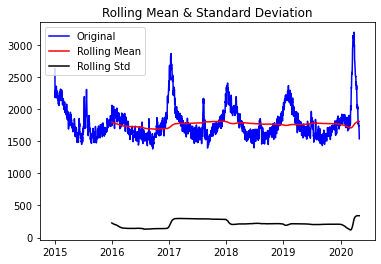

Results of Dickey-Fuller Test:
Test Statistic                   -5.041050
p-value                           0.000018
#Lags Used                       16.000000
Number of Observations Used    1930.000000
Critical Value (1%)              -3.433743
Critical Value (5%)              -2.863039
Critical Value (10%)             -2.567568
dtype: float64
X is stationary


In [155]:
#verifico che il trend sia stazionario
test_stationarity(ts)

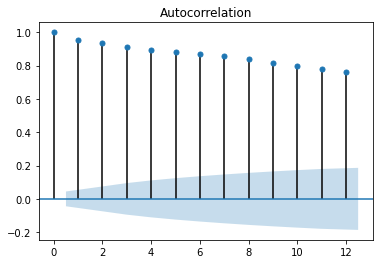

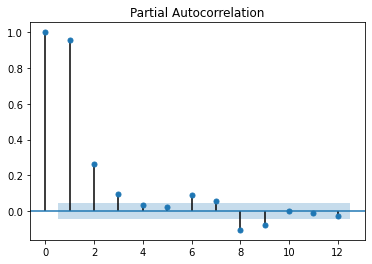

In [156]:
#grafici di autocorrelazione e autocorrelazione parziale
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts, lags =12)
plot_pacf(ts, lags =12)
plt.show()

In [265]:
#suddivisione del trend della serie in train e test
from datetime import datetime
train_end = datetime(2019,10,31)
test_end = datetime (2019,12,31)
covid_end = datetime(2020,4,30)

# periodo dal 01-01-2015 al 31-10-2019
train = ts[:train_end]

# periodo dal 01-11-2019 al 31-12-2019
test = ts[train_end + timedelta(days=1): test_end]

#trend COVID: periodo dal 01-01-2020 al 30-04-2020
trend_covid = ts[test_end + timedelta(days=1): covid_end]

In [266]:
#creazione del modello
from statsmodels.tsa.arima_model import ARIMA
p = 1
q = 8
d = 0
model = ARIMA(train, order=(p,d,q))
model_fit = model.fit(disp=-1)
print(model_fit.summary())

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                              ARMA Model Results                              
Dep. Variable:                 Totale   No. Observations:                 1765
Model:                     ARMA(1, 8)   Log Likelihood              -10015.881
Method:                       css-mle   S.D. of innovations             70.457
Date:                Fri, 18 Sep 2020   AIC                          20053.762
Time:                        11:23:15   BIC                          20113.997
Sample:                    01-01-2015   HQIC                         20076.019
                         - 10-31-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1790.6616     70.429     25.425      0.000    1652.624    1928.700
ar.L1.Totale     0.9881      0.004    225.555      0.000       0.980       0.997
ma.L1.Totale    -0.3494      0.025    -14.25

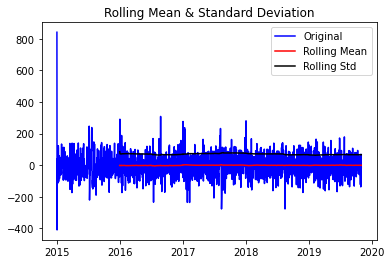

Results of Dickey-Fuller Test:
Test Statistic                  -45.111192
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1764.000000
Critical Value (1%)              -3.434062
Critical Value (5%)              -2.863180
Critical Value (10%)             -2.567643
dtype: float64
X is stationary


In [267]:
#verifico che i residui della serie siano stazionari
residuals = model_fit.resid
test_stationarity(residuals)

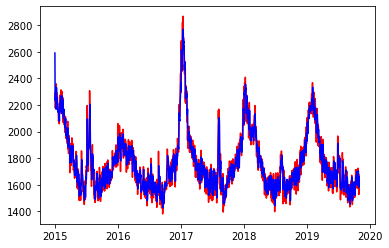

In [284]:
plt.plot (train.iloc[1:], color='red')
plt.plot (model_fit.fittedvalues.iloc[1:], color = 'blue')
plt.show()

In [269]:
model_fit.fittedvalues

Data
2015-01-01    1790.661623
2015-01-02    2591.478055
2015-01-03    2292.515915
2015-01-04    2233.222115
2015-01-05    2256.919914
                 ...     
2019-10-27    1629.508721
2019-10-28    1664.043570
2019-10-29    1580.418524
2019-10-30    1639.203168
2019-10-31    1627.639383
Length: 1765, dtype: float64

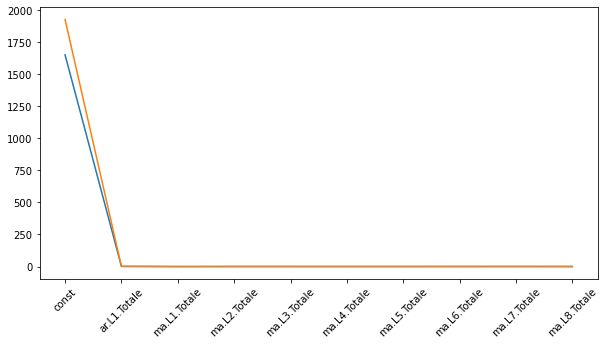

In [270]:
#Intervallo di confidenza del modello
conf = model_fit.conf_int()
plt.figure(figsize=(10,5))
plt.plot(conf)
plt.xticks(rotation=45)
plt.show()

In [271]:
#get prediction start and end dates
pred_start = test.index[0]
pred_end = test.index[-1]

print(pred_end)
print(pred_start)

2019-12-31 00:00:00
2019-11-01 00:00:00


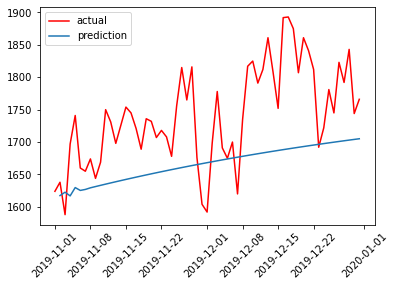

In [272]:
#predizione del modello sul test
predictions_test= model_fit.predict(start=pred_start, end=pred_end)

plt.plot(test, color='red', label='actual')
plt.plot(predictions_test.iloc[1:], label='prediction' )
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [273]:
len(predictions_test)
len(test)

61

In [274]:
print(predictions_test)

2019-11-01    1617.003522
2019-11-02    1617.431132
2019-11-03    1622.645984
2019-11-04    1616.953090
2019-11-05    1629.784352
                 ...     
2019-12-27    1700.921504
2019-12-28    1701.988306
2019-12-29    1703.042426
2019-12-30    1704.084015
2019-12-31    1705.113222
Freq: D, Length: 61, dtype: float64


In [275]:
#calcolo RMSE
import numpy as np
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(predictions_test, test)/(np.max(test)-np.min(test))
print('RMSE = ', nrmse)

RMSE =  0.3193306805770519


In [276]:
#get prediction start and end dates
start = ts.index[0]
end = ts.index[-1]


print(end)
print(start)

2020-04-30 00:00:00
2015-01-01 00:00:00


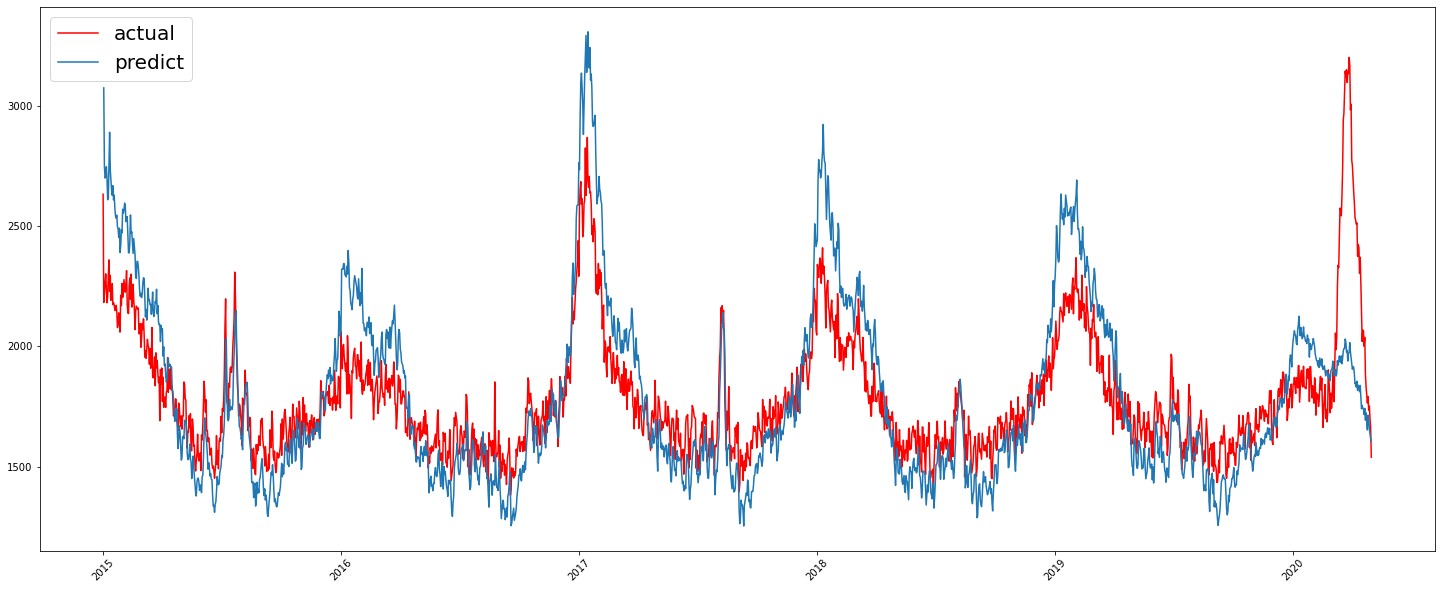

In [277]:
# predizione sul trend della serie storica includendo il 2020
predictions = model_fit.predict(start=start, end=end)

predictions_tot = predictions * ts_seasonal

plt.figure(figsize=(25,10))
plt.plot(ts, color='red', label='actual')
plt.plot(predictions_tot.iloc[1:], label='predict')
plt.xticks(rotation=45)
plt.legend(prop={'size': 20})
plt.show()

In [278]:
predictions_tot

2015-01-01    2088.271775
2015-01-02    3073.522680
2015-01-03    2746.790297
2015-01-04    2698.993709
2015-01-05    2705.575007
                 ...     
2020-04-26    1695.750141
2020-04-27    1658.824021
2020-04-28    1637.953505
2020-04-29    1615.627335
2020-04-30    1606.344938
Freq: D, Length: 1947, dtype: float64

In [279]:
# predictions_tot.conf_int()

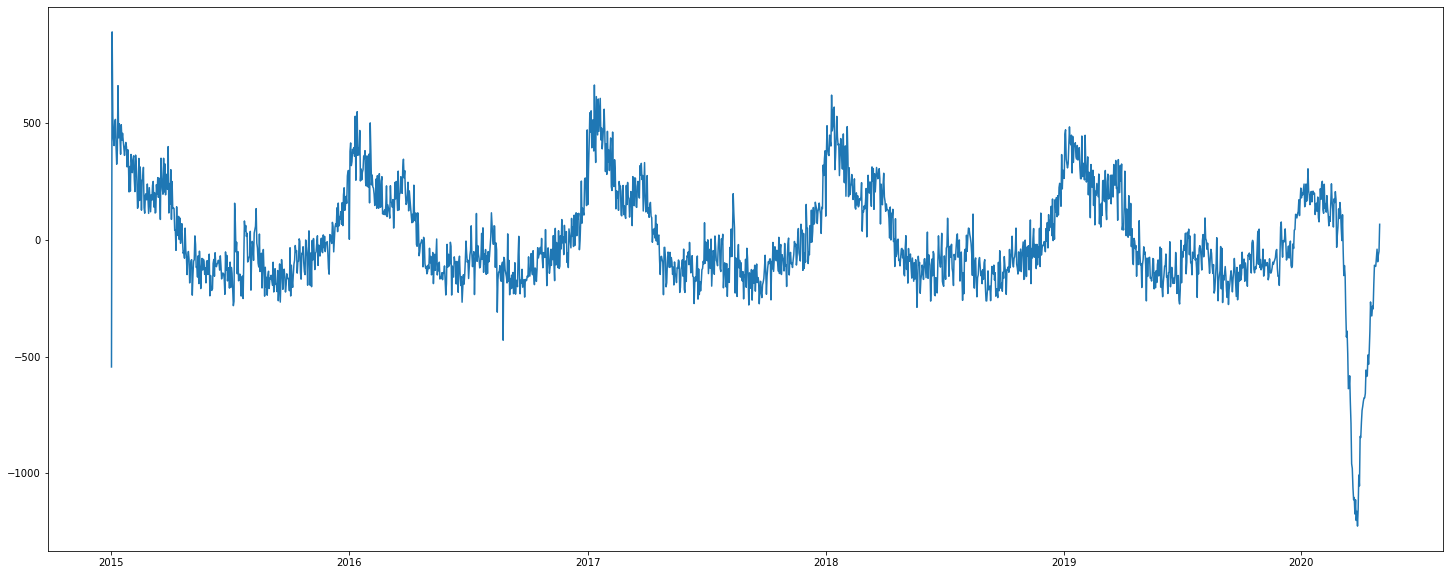

In [280]:
diff_predictions_tot = (predictions_tot - ts)
plt.figure(figsize=(25,10))
plt.plot(diff_predictions_tot)
plt.show()

In [281]:
predictions_tot.to_csv('csv/predictions_daily_ARIMA.csv')